In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [2]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform, PointLights, TexturesVertex, Textures
import matplotlib.pyplot as plt
import trimesh

from utils import general_utils
from utils import visualization_tools
from utils.eval_utils import eval_metrics
#from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [3]:
#models_dir = "/home/svcl-oowl/dataset/ShapeNetCore.v1"
#class_id = "03001627"
#instance = "cbcc5cd1aec9f3413aa677469bbdd68c"
#model_path = os.path.join(models_dir, class_id, instance, "model_watertight.obj")
model_path = "data/test_gt_mesh/meshes/f68ecc9ec512915f36d8dd30a594b2af.obj"
device = torch.device("cuda:0")
mesh = general_utils.load_untextured_mesh(model_path, device)

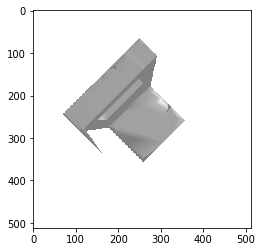

In [21]:
dist = 1
elev = 89
azim = 45
R, T = look_at_view_transform(dist, elev, azim)

render = general_utils.render_mesh(mesh, R, T, device)
plt.imshow(render[0, ..., :3].detach().cpu().numpy())

In [ ]:
num_verts = mesh.verts_packed().shape[0]
verts_rgb = torch.rand((1, num_verts,3), device=device)
print(verts_rgb)
print(verts_rgb.shape)
mesh.textures = TexturesVertex(verts_rgb)

In [ ]:
dist = 1
elev = 35
azim = 25
R, T = look_at_view_transform(dist, elev, azim)

no_lights = PointLights(device=device, ambient_color=((0.5,0.5,0.5),), diffuse_color=((0.0,0.0,0.0),), specular_color=((0.0,0.0,0.0),))
render = general_utils.render_mesh(mesh, R, T, device, custom_lights=no_lights)
#render = general_utils.render_mesh(mesh, R, T, device)
plt.imshow(render[0, ..., :3].detach().cpu().numpy())

In [ ]:
def render_pointcloud(verts_padded, verts_rgb, dist, elev, azim, device):

    # make pointcloud 
    point_cloud = Pointclouds(points=verts_padded, features=verts_rgb)

    # get render
    raster_settings = PointsRasterizationSettings(image_size=512, radius = 0.008,points_per_pixel = 10)
    R, T = look_at_view_transform(dist, elev, azim) 
    cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
    renderer = PointsRenderer(rasterizer=rasterizer,compositor=AlphaCompositor(background_color=(1, 1, 1,0)))
    
    # show render
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.grid("off")
    plt.axis("off")

In [ ]:
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    OpenGLPerspectiveCameras, 
    NormWeightedCompositor
)
